In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

## simulating an autoregressive moving average process

before jumping into using a dataset, we will create a $ARMA(p,q)$ process, specifically a $ARMA(1,1)$ process defined by the equation:

$y_t = 0.33y_{t–1} + 0.9\epsilon_{t–1} + \epsilon_{t}$

Let's remember that $ARMA(1,1)$ is defined by:

$ARMA(1,1) := y_t = C + \phi_1y_{t-1} + \mu + \theta\epsilon_{t-1}+ \epsilon{t}$

So you might be wondering where is $\mu$ and $C$, well in the first equation they are equal to $0$. So let's not worry about them right now

The purpose of this simulation is to show that we cannot use the old plots we are used to: ACF and PACF, to get $p$ and $q$ anymore

In [2]:
np.random.seed(42)

ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

In [3]:
arma_process = sm.tsa.ArmaProcess(ar1, ma1).generate_sample(nsample = 1000)

now that we have our process let's do the steps.

In [4]:
adf = sm.tsa.stattools.adfuller(arma_process)
print(f'adf statistic {adf[0]}')
print(f'p-value {adf[1]}')

adf statistic -6.429878682042654
p-value 1.7078466680100388e-08


since $p < 0.05$ we can reject the null hypothesis and conclude that we have a stationary process.

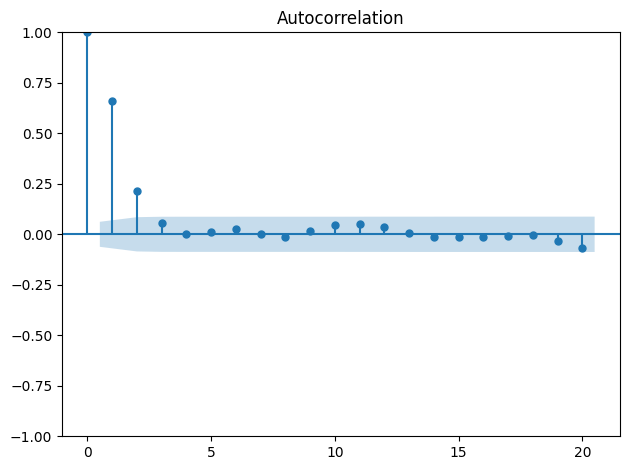

In [5]:
sm.graphics.tsa.plot_acf(arma_process, lags = 20)
plt.tight_layout()

we can see a sinusoidal pattern in the plot, and the last significant lag is 2. Take into account that we did our process specifically to be MA(1) so this plot is not that helpful

/Users/bsantanad/development/n/time-series/venv/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


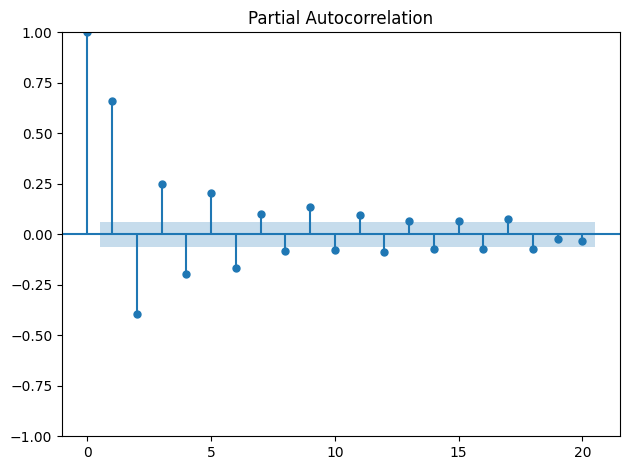

In [6]:
sm.graphics.tsa.plot_pacf(arma_process, lags = 20)
plt.tight_layout()

we see the sinusoidal pattern again so we would not be able to calc $p$ from here

As explained in the notes we'll use AIC to determine $p$ and $q$. What is AIC? check the notes :)

In [7]:
# create a list for our possible values of p and q
ps = range(0, 4)
qs = range(0, 4)

# list of all unique combinations of the lists above
order_l = list(itertools.product(ps, qs))

In [10]:
def optimize_arma(
        endog: pd.Series | list, order_l: list) -> pd.DataFrame:
    '''
    Given a list of combinations of p,q test different combinations of arma
    orders, and compare them against each other using Akaike Information
    criterion.

    :param endog typing.Union[pd.Series, list]: the observed time-series process
    :param order_l list: list of all combinations of p and q

    :returns: dataframe with two columns, one the combination of p and q,
        the other the AIC score, the dataframe is already sorted.
    :rtype: pd.DataFrame
    '''

    results = []

    for order in order_l:
        try:
            model = sm.tsa.statespace.SARIMAX(
                endog, 
                order = (order[0], 0, order[1]),
                simple_differencing = False,
            )
            model = model.fit(disp = False)
        except:
            continue
    
        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    # sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by = 'AIC', ascending = True)
    result_df = result_df.reset_index(drop = True)

    return result_df

In [9]:
result_df = optimize_arma(arma_process, order_l)
result_df

/Users/bsantanad/development/n/time-series/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/bsantanad/development/n/time-series/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/bsantanad/development/n/time-series/venv/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2805.861752
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


We can see that the top candidate is 1,1 which we know is true becuase we simulated an ARMA process of that order

next steps:

- get residuals
- plot q-q plot
- get ljung-box statistic

In [14]:
model = sm.tsa.statespace.SARIMAX(
    arma_process, 
    order = (1, 0, 1),
    simple_differencing = False,
)
model = model.fit(disp = False)
residuals = model.resid

with the Q-Q plot we will compare our resdiuals to a normal distribution to see if they represent white noise

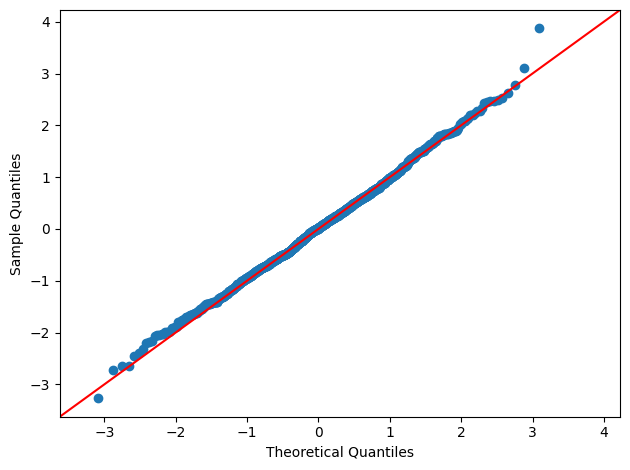

In [18]:
sm.qqplot(residuals, line = '45')
plt.tight_layout()

It look a hell of a lot similar to the normal distribution, so we are in the right track. There is another function that displays more plots on the residuals

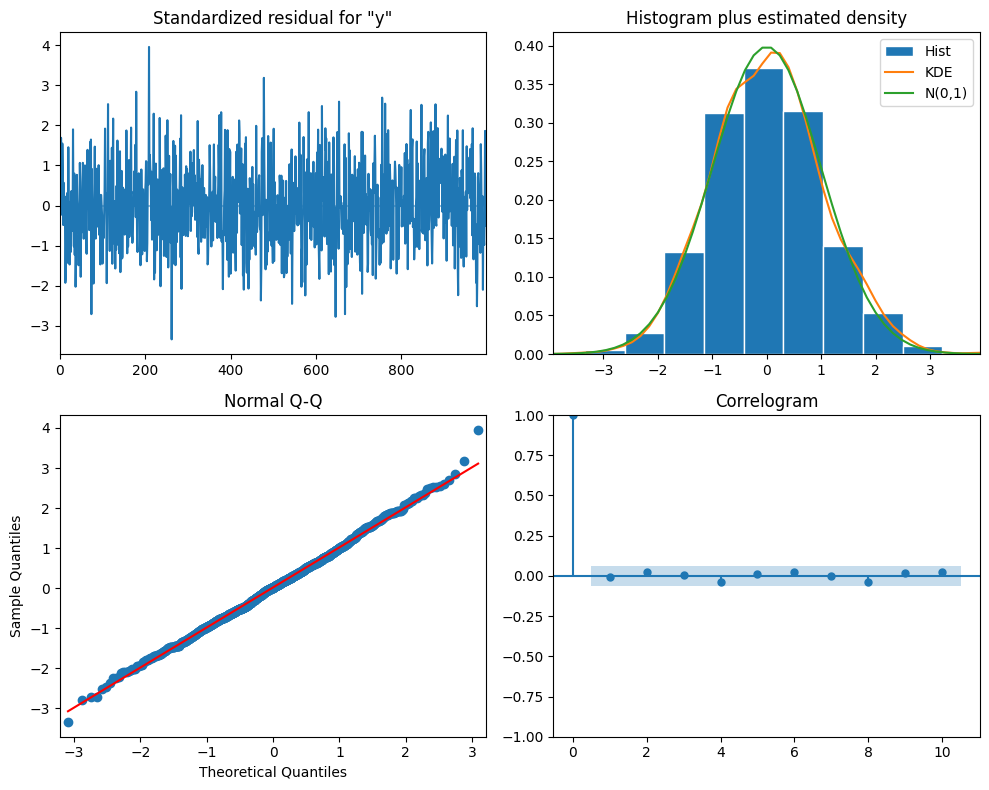

In [21]:
model.plot_diagnostics(figsize = (10, 8))
plt.tight_layout()

1. top left, the residuals are stationary they dont have any trend, this is good, because that is the behaviour of a normal dist
2. top right, histogram with the residuals, it looks like a normal distribution
3. bottom left, q-q plot
4. autocorrelation function of the residuals

we are just missing the ljung-box statistic

In [33]:
sm.stats.acorr_ljungbox(residuals, lags = [10])

,lb_stat,lb_pvalue
10,5.246805,0.874093


> The resulting list of p-values shows that each is above 0.05. Therefore, at each lag, the null hypothesis cannot be rejected, meaning that the residuals are independently dis- tributed and uncorrelated.

## forecasting bandwidth usage

bandwidth is defined as the max rate of data than can be transfered (bits per second)